In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # matris işlemleri 
import pandas as pd # verisetini yükleme 
import os  
from pickle import load,dump  # dosya kaydetme , yükleme 
from tqdm import tqdm # prefetch dataset üzerinde gezinme 
import time

import tensorflow as tf 
from tensorflow.data.experimental import AUTOTUNE 
from tensorflow.data import Dataset  # dataset oluşturma 


from tensorflow import keras 
from keras.models import Model,load_model # model oluşturma, model yükleme 
from tensorflow.keras import layers
# Image Operations 
from keras.applications.inception_v3 import InceptionV3,preprocess_input # görüntü extract modeli, preprocess 
from tensorflow.io import read_file # görüntüyü dosyadan okuma 
from tensorflow.image import decode_png,resize # görüntüyü decode etme , görüntüyü resize etme 

# Text operations
from keras.preprocessing.sequence import pad_sequences # padding ekleme 
from keras.preprocessing.text import Tokenizer # sözlük yapısı oluşturma, tokenizer oluşturma, indekslerden ulaşma, sekans oluşturma vs. 


from sklearn.model_selection import train_test_split # verisetini bölme 
import nltk 
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
import matplotlib.pyplot as plt 

In [2]:
kayit_yeri = '/content/drive/MyDrive/bm496_7haziran'
dataset_path = os.path.join(kayit_yeri,'dataset')
csv_path = os.path.join(dataset_path,'frontal_reports',"clean_indiana_ds.csv")
images_path = os.path.join(dataset_path,'frontal_images')

data_df = pd.read_csv(csv_path)

In [3]:
data_df.tail()

,Id,Findings
3136,995_IM-2478-1001.png,sternotomy sutures bypass grafts placed interv...
3137,997_IM-2479-1001.png,calcified mediastinal no focal areas consolida...
3138,998_IM-2479-1001.png,cardiomediastinal silhouette demonstrates norm...
3139,999_IM-2480-1001.png,lungs clear bilaterally no focal consolidation...
3140,999_IM-2480-3001.png,lungs clear bilaterally no focal consolidation...


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        3141 non-null   object
 1   Findings  3141 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


In [5]:
class myutils:
    def createDictStructure(self,dataset,images_fullpath):
        '''
        Fonk: Dataframe yapısından dict yapısı oluşturan fonksiyon
        Args:
        :param dataset: Görüntü id'lerini ve finding'lerini içeren dataframe yapısı
        :param images_fullpath: Görüntü dosyalarının bulunduğu konum
        :return: {görüntü_full_path:finding} yapısı
        :return: tüm cümleleri(captionları) içeren liste yapısı
        '''
        findings = dataset['Findings'].values
        images_ids = dataset['Id'].values
        report_mapping = {}
        finding_list = []
        for i in range(len(findings)):
            img_name = images_ids[i]
            img_name = os.path.join(images_fullpath, img_name.strip())

            finding = "<start> " + findings[i] + " <end>"
            finding_list.append(finding)
            report_mapping[img_name] = finding
        print("INFO: Tüm veri kümesi için { IMG_FULLPATH: CAPTION } dict yapısı oluşturuldu.")
        return report_mapping

    def saveToFile(self,data, filename):
        '''
         Args:  data : bulgular, img_idler ya da öznitelikler ( List)
                filename:cümleleri/image idleri / öznitelikleri içeren dosyanın tam yolu
        '''
        try:
            dump(data, open(filename, 'wb'))
            print(f"{filename} dosya kaydedildi")
        except:
            raise Exception(f'{filename} dosya kaydedilemedi..!')

    def readFromFile(self,filename):
        '''
        Bu fonksiyon daha önceden çıkarılmış feature'ları yükler.
        input : data: tüm cümleleri/image'idleri içeren yapı
              filename: yapıyı kaydedeceğimiz dosyanın adıyla beraber tam dosya yolu.
        '''
        data = load(open(filename,'rb'))
        print(filename.split('/')[-1]," dosyası yüklendi.. len:",len(data))
        return data



In [6]:
helper = myutils()

In [7]:
dataset = helper.createDictStructure(dataset=data_df,images_fullpath=images_path)

INFO: Tüm veri kümesi için { IMG_FULLPATH: CAPTION } dict yapısı oluşturuldu.


In [8]:
all_images_fullpaths = list(dataset.keys())
all_findings = list(dataset.values())

In [9]:
print("img_name_vector[0]:",all_images_fullpaths[0])
print("train_captions[0]:",all_findings[0])

img_name_vector[0]: /content/drive/MyDrive/bm496_7haziran/dataset/frontal_images/1_1_IM-0001-4001.png
train_captions[0]: <start> cardiac silhouette mediastinum size within normal limits no pulmonary edema no focal consolidation no pleural effusion no evidence pneumothorax <end>


In [10]:
def goruntuYukle(image_path):
   img = read_file(image_path)
   img = decode_png(img, channels=3)
   img = resize(img, (299, 299))
   img = preprocess_input(img)
   return img, image_path

In [11]:
img,img_path = goruntuYukle(all_images_fullpaths[0])
print("Img_path:",img_path,"\nImg.shape:",img.shape)

Img_path: /content/drive/MyDrive/bm496_7haziran/dataset/frontal_images/1_1_IM-0001-4001.png 
Img.shape: (299, 299, 3)


In [12]:
BATCH_SIZE = 64 
image_dataset = Dataset.from_tensor_slices(all_images_fullpaths).map(goruntuYukle, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [13]:
# Öznitelik çıkarma 
def load_extraction_model(extraction_model):
  input_shape = extraction_model.input
  output_shape = extraction_model.layers[-1].output
  extraction_model = Model(input_shape, output_shape)
  return extraction_model

IMAGE_SIZE = (299,299,3)
extraction_model_path = InceptionV3(include_top=False,input_shape=IMAGE_SIZE) # Inception V3 mimarisini default olarak weights='imagenet' olarak almaktadır. 

extraction_model = load_extraction_model(extraction_model_path)

87924736/87910968 [==============================] - 1s 0us/step


In [14]:
print("Extraction Model\nInput shape: {}\nOutput shape:{}".format(extraction_model.input_shape,extraction_model.output_shape))
extraction_model_path = os.path.join(kayit_yeri,'modeller','extraction_model2')
print("PATH:",extraction_model_path)
extraction_model.save(extraction_model_path,save_format='tf')

Extraction Model
Input shape: (None, 299, 299, 3)
Output shape:(None, 8, 8, 2048)
PATH: /content/drive/MyDrive/bm496_7haziran/modeller/extraction_model2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/bm496_7haziran/modeller/extraction_model2/assets


In [15]:
extractionModel_fromFile = load_model(extraction_model_path)
print("FROM FILE : Extraction Model\nInput shape: {}\nOutput shape:{}".format(extractionModel_fromFile.input_shape,extractionModel_fromFile.output_shape))

FROM FILE : Extraction Model
Input shape: (None, 299, 299, 3)
Output shape:(None, 8, 8, 2048)


In [16]:
features_filepath = os.path.join(dataset_path,'frontal_images_features')

# Öznitelikleri çıkartıp tekrar kullanmak için npy formatında kaydet.
'''
for img, path in tqdm(image_dataset):
   batch_features = extractionModel_fromFile(img)
   batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
   for bf, p in zip(batch_features, path):
      filename = p.numpy().decode("utf-8").split('\\')[-1].split('.')[0]
      path_of_feature = os.path.join(features_filepath,filename)
      np.save(path_of_feature, bf.numpy())
'''

'\nfor img, path in tqdm(image_dataset):\n   batch_features = extractionModel_fromFile(img)\n   batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))\n   for bf, p in zip(batch_features, path):\n      filename = p.numpy().decode("utf-8").split(\'\\\')[-1].split(\'.\')[0]\n      path_of_feature = os.path.join(features_filepath,filename)\n      np.save(path_of_feature, bf.numpy())\n'

In [17]:
tokenizer = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ') # sözlük olustur
tokenizer.fit_on_texts(all_findings) 
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

captions_sequences = tokenizer.texts_to_sequences(all_findings) # sequence'e dönüştür.
captions_vector = pad_sequences(captions_sequences, padding='post') # padding uygula 
VOCABSIZE = len(tokenizer.word_index)+1
SEQ_LENGTH = len(captions_vector[0])

In [18]:
print("Tokenizer examples:",list(tokenizer.word_index.keys())[:10],"\nVocabsize:",VOCABSIZE,"\nMax Sequence Length:",SEQ_LENGTH)

Tokenizer examples: ['<unk>', 'no', 'normal', '<start>', '<end>', 'pleural', 'pneumothorax', 'effusion', 'heart', 'lungs'] 
Vocabsize: 1386 
Max Sequence Length: 44


In [19]:
img_fullpaths_trainval, img_fullpaths_test, findings_trainval, findings_test = train_test_split(all_images_fullpaths,captions_vector, test_size=0.05, random_state=0)
img_fullpaths_train, img_fullpaths_val, findings_train, findings_val = train_test_split(img_fullpaths_trainval,findings_trainval, test_size=0.05, random_state=0)

In [22]:
BATCH_SIZE = 64 
BUFFER_SIZE = 1000

def oznitelikBul(img_name, cap):
   filename = img_name.decode('utf-8').split('\\')[-1].split('.')[0] + '.npy'
   img_feature_filepath = os.path.join(features_filepath,filename)
   img_tensor = np.load(img_feature_filepath)
   return img_tensor, cap

# {Image full path: öznitelik değeri} şeklinde tf map yapısında dataset oluştur.
dataset = tf.data.Dataset.from_tensor_slices((img_fullpaths_train, findings_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(oznitelikBul, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
# Positional Encoding yapmak için kullanacağımız nesne , görüntüler için toEncoder fonksiyonu, captionlar için toDecoder fonksiyonu kullanılır.
# Matematiksel formüller Attention is All you need makalesinden alınmıştır.
class PositionEncoder:
  def aci_hesapla(self,pos, i, embed_dim):
    aci_orani = 1 / np.power(10000, (2 * (i//2)) / np.float32(embed_dim))
    return pos * aci_orani

  def toDecoder(self,pos, embed_dim):
    aci_orani = self.aci_hesapla(np.arange(pos)[:, np.newaxis],np.arange(embed_dim)[np.newaxis, :],embed_dim)

    aci_orani[:, 0::2] = np.sin(aci_orani[:, 0::2])
    aci_orani[:, 1::2] = np.cos(aci_orani[:, 1::2])
    pos_encoding = aci_orani[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

  def toEncoder(self,satir,sutun,embed_dim):
    assert embed_dim % 2 == 0
    satir_pos = np.repeat(np.arange(satir),sutun)[:,np.newaxis]
    sutun_pos = np.repeat(np.expand_dims(np.arange(sutun),0),satir,axis=0).reshape(-1,1)

    aci_orani_satir = self.aci_hesapla(satir_pos,np.arange(embed_dim//2)[np.newaxis,:],embed_dim//2)
    aci_orani_sutun = self.aci_hesapla(sutun_pos,np.arange(embed_dim//2)[np.newaxis,:],embed_dim//2)

    aci_orani_satir[:, 0::2] = np.sin(aci_orani_satir[:, 0::2])
    aci_orani_satir[:, 1::2] = np.cos(aci_orani_satir[:, 1::2])
    aci_orani_sutun[:, 0::2] = np.sin(aci_orani_sutun[:, 0::2])
    aci_orani_sutun[:, 1::2] = np.cos(aci_orani_sutun[:, 1::2])
    pos_encoding = np.concatenate([aci_orani_satir,aci_orani_sutun],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Maskeleme operasyonu eğer 0 ise True değilse False döndürür. daha sonra bu dizi float32 formatına convret edilip standart input shape'ine resize edilir.
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# Maske oluşturma . 
def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

# Scaled dot product [q*k / sqrt(dk)] * v
def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dimension_of_k = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dimension_of_k)
   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

# Çok kafalı yapı oluşturma 
class MultiHeadAttention(layers.Layer):
   def __init__(self, embed_dim, nheads):
      super(MultiHeadAttention, self).__init__()
      self.nheads = nheads # Kafa sayısı 
      self.embed_dim = embed_dim # Embedding uzayı boyutu 
      assert embed_dim % self.nheads == 0 # Embedding kafa sayısına bölünüyor mu kontrol et . Yoksa hata verir.
      self.depth = embed_dim // self.nheads
      self.wq = tf.keras.layers.Dense(embed_dim) # Query ağırlıklları
      self.wk = tf.keras.layers.Dense(embed_dim) # Key ağırlıkları
      self.wv = tf.keras.layers.Dense(embed_dim) # Value ağırlıkları
      self.dense = tf.keras.layers.Dense(embed_dim) # Birleştirici katman 

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.nheads, self.depth)) # embed dim // kafa sayısına göre buranın shape'i belirlenir. Bu sebeple embed dim head'e bölünebilir olmaldıır.
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, embed_dim)
      k = self.wk(k)  # (batch_size, seq_len, embed_dim)
      v = self.wv(v)  # (batch_size, seq_len, embed_dim)

      q = self.split_heads(q, batch_size)  # (batch_size, nheads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, nheads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, nheads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, nheads, depth)

      concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.embed_dim))  # (batch_size, seq_len_q, embed_dim)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, embed_dim)
      return output, attention_weights

def point_wise_feed_forward_network(embed_dim, ffn_dim):
     return tf.keras.Sequential([ tf.keras.layers.Dense(ffn_dim, activation='relu'), tf.keras.layers.Dense(embed_dim)])  # (batch_size, seq_len, embed_dim)])

# Görüntü inputunu geçirdiğimiz encoder blok . 
# Attention is all you need Makalesindeki ypaıya göre oluşturulmuştur.
# Bir encoder katmanı
class EncoderLayer(layers.Layer):
   def __init__(self, embed_dim, num_heads, ffn_dim, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(embed_dim, num_heads) # multi head attention
      self.ffn = point_wise_feed_forward_network(embed_dim, ffn_dim) # Feed forward network 
      # Normalization layerları
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      #Dropout layerları ( overfiti azaltmak için )
      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, embed_dim) # attention çıktısını al 
      attn_output = self.dropout1(attn_output, training=training) # bu çıktıyı dropouttan geçir 
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, embed_dim) # önceki input ile çıktıyı concat et sonra normalize et. 

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, embed_dim) # feed forwarddan geçir 
      ffn_output = self.dropout2(ffn_output, training=training) # çıktısını al dropouttan geçir 
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, embed_dim) # inputu ve çıktısını concat et normalize et . 
      return out2
    
# Captionları geçirdiğimiz ve ilerleyen aşamalarda encoder'ın çıktısını kullandığımız blok.
# Attention is all you need Makalesindeki ypaıya göre oluşturulmuştur.
# Bir decoder katmanı
class DecoderLayer(layers.Layer):
   def __init__(self, embed_dim, nheads, ffn_dim, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(embed_dim, nheads)
      self.mha2 = MultiHeadAttention(embed_dim, nheads)
      # Encoder'ın çıktısı ile decoderı birleştiren katman 
      self.ffn = point_wise_feed_forward_network(embed_dim, ffn_dim)
      # Normalization layerları 
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      # Overfit kaçınmak için dropout katmanları 
      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, embed_dim)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embed_dim)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, embed_dim)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, embed_dim)

      return out3, attn_weights_block1, attn_weights_block2

# Encoder bloğu 
class Encoder(layers.Layer):
   def __init__(self, num_layers, embed_dim, nheads, ffn_dim, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.embed_dim = embed_dim
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.embed_dim,activation='relu')
      self.pos_encoding = PositionEncoder().toEncoder(row_size,col_size,self.embed_dim)

      self.enc_layers = [EncoderLayer(embed_dim, nheads, ffn_dim, rate) for _ in range(num_layers)] # Encoder katmanı katman sayısı kadar oluştur
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), embed_dim)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, embed_dim)

# Decoder bloğu 

class Decoder(layers.Layer):
   def __init__(self, num_layers,embed_dim,nheads,ffn_dim, vocabsize, rate=0.1):
      super(Decoder, self).__init__()
      self.embed_dim = embed_dim
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(vocabsize, embed_dim)
      self.pos_encoding = PositionEncoder().toDecoder(vocabsize, embed_dim) # hizalama 

      self.dec_layers = [DecoderLayer(embed_dim, nheads, ffn_dim, rate)for _ in range(num_layers)] # Decoder katmanı katman sayısı kadar oluştur
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, embed_dim)
      x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights


class Transformer(Model):
   def __init__(self, num_layers, embed_dim, nheads, ffn_dim,row_size,col_size,vocabsize, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, embed_dim, nheads, ffn_dim,row_size,col_size, rate) # Encoder bloğunu oluştur
      self.decoder = Decoder(num_layers, embed_dim, nheads, ffn_dim,vocabsize, rate)
      self.final_layer = tf.keras.layers.Dense(vocabsize) 

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, embed_dim  )
      dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocabsize)
      return final_output, attention_weights

In [24]:
NUM_LAYER = 6 # encoder-decoder blok tekrar sayısı
EMBED_DIM = 512 # embedding dimension
FFN_DIM = 3072 #feed-forward network dimension 
NHEADS = 8 # kafa sayısı
ROW_SIZE = 8 # encoder-input- hizalama satir sayisi
COL_SIZE = 8 # encoder-input- hizalama sutun sayisi
DROPOUT_RATE = 0.1 # dropout oranı 

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, embed_dim, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.embed_dim = embed_dim
      self.embed_dim = tf.cast(self.embed_dim, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

In [26]:
learning_rate = CustomSchedule(EMBED_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [27]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(NUM_LAYER,EMBED_DIM,NHEADS,FFN_DIM,ROW_SIZE,COL_SIZE,VOCABSIZE,rate=DROPOUT_RATE)

In [28]:
def create_masks_decoder(seq):
   look_ahead_mask = create_look_ahead_mask(tf.shape(seq)[1])
   dec_target_padding_mask = create_padding_mask(seq)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [29]:
@tf.function
def train_step(img_tensor, seq):
   seq_inp = seq[:, :-1]
   seq_real = seq[:, 1:]
   decoder_mask = create_masks_decoder(seq_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, seq_inp,True, decoder_mask)
      loss = loss_function(seq_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(seq_real, predictions)
   

In [31]:
EPOCHS = 50
losses = []
costs = []
print(f"Eğitim başladı.\EPOCHS:{EPOCHS}\tBATCH_SIZE:{BATCH_SIZE}")
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (img_tensor, seq)) in enumerate(dataset):
        train_step(img_tensor, seq)
        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    losses.append(train_loss.result())
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,train_loss.result(),train_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Eğitim başladı.\EPOCHS:50	BATCH_SIZE:64
Epoch 1 Batch 0 Loss 7.4394 Accuracy 0.0007
Epoch 1 Batch 20 Loss 7.1995 Accuracy 0.0105
Epoch 1 Batch 40 Loss 6.7928 Accuracy 0.0197
Epoch 1 Loss 6.7246 Accuracy 0.0203
Time taken for 1 epoch: 1038.553260087967 secs

Epoch 2 Batch 0 Loss 6.1418 Accuracy 0.0302
Epoch 2 Batch 20 Loss 5.8384 Accuracy 0.0298
Epoch 2 Batch 40 Loss 5.7545 Accuracy 0.0298
Epoch 2 Loss 5.7368 Accuracy 0.0299
Time taken for 1 epoch: 19.579822301864624 secs

Epoch 3 Batch 0 Loss 5.5354 Accuracy 0.0316
Epoch 3 Batch 20 Loss 5.4147 Accuracy 0.0433
Epoch 3 Batch 40 Loss 5.3122 Accuracy 0.0526
Epoch 3 Loss 5.2775 Accuracy 0.0547
Time taken for 1 epoch: 19.789469957351685 secs

Epoch 4 Batch 0 Loss 4.9324 Accuracy 0.0959
Epoch 4 Batch 20 Loss 4.7363 Accuracy 0.0998
Epoch 4 Batch 40 Loss 4.5567 Accuracy 0.1136
Epoch 4 Loss 4.5251 Accuracy 0.1156
Time taken for 1 epoch: 19.894974946975708 secs

Epoch 5 Batch 0 Loss 4.0656 Accuracy 0.1392
Epoch 5 Batch 20 Loss 3.9641 Accuracy 0.1

In [32]:
def evaluate(image,extraction_model,prediction_model,tokenizer,SEQ_LENGTH):
   temp_input = tf.expand_dims(goruntuYukle(image)[0], 0)
   img_tensor_val = extraction_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(SEQ_LENGTH):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = prediction_model(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

In [37]:
i = 25
eval1,_,_ = evaluate(img_fullpaths_val[i],extractionModel_fromFile,transformer,tokenizer,SEQ_LENGTH)
res1 = [' '.join(e for e in eval1)]
eval2,_,_ = evaluate(img_fullpaths_val[i+5],extractionModel_fromFile,transformer,tokenizer,SEQ_LENGTH)
res2 = [' '.join(e for e in eval2)]
print("PRED 1:",res1)
print("PRED 2:",res2)

PRED 1: ['normal heart size mediastinal contours atherosclerotic calcifications aortic no focal airspace consolidation no pleural effusion pneumothorax visualized osseous structures unremarkable appearance']
PRED 2: ['heart size mediastinal contour normal pulmonary vascularity normal lungs clear no pleural effusions pneumothoraces']


In [38]:
extraction_model = extractionModel_fromFile
prediction_model = transformer
tokenizer = tokenizer
seq_length = SEQ_LENGTH
all_images = img_fullpaths_val
all_captions = findings_val

In [40]:
def findReferencesAndCandidates(all_images,all_captions,extraction_model,prediction_model,tokenizer,seq_length):
    '''
    all_images: tüm resimlerin dosya yolları
    all_captions: tüm resimlerin yorumları
    '''
    references = []
    candidates = []
    for idx in range(len(all_images)):
        image = all_images[idx]
        real_caption = ' '.join([tokenizer.index_word[i] for i in all_captions[idx] if i not in [0]])
        caption,result,attention_weights = evaluate(image,extraction_model,prediction_model,tokenizer,seq_length)

        first = real_caption.split(' ', 1)[1]
        real_caption = first.rsplit(' ', 1)[0]

        for i in caption:
           if i=="<unk>":
              caption.remove(i)

        for i in real_caption:
           if i=="<unk>":
              real_caption.remove(i)

        result_join = ' '.join(caption)
        result_final = result_join.rsplit(' ', 1)[0]
        real_appn = []
        real_appn.append(real_caption.split())
        reference = real_appn
        candidate = caption
        print(f"ADIM {idx}:\nREAL: {reference}\nPRED: {candidate}")
        references.append(reference)
        candidates.append(candidate)
    return references,candidates

def showSample(images,references,candidates):
    image = images[3]
    temp_image = np.array(Image.open(image))
    print("Real:",references[3])
    print("Prediction:",candidates[3])
    plt.imshow(temp_image)
    

In [41]:
refs,cands = findReferencesAndCandidates(all_images,all_captions,extraction_model,prediction_model,tokenizer,seq_length)

ADIM 0:
REAL: [['heart', 'normal', 'size', 'contour', 'no', 'mediastinal', 'widening', 'no', 'focal', 'air', 'space', 'disease', 'prominent', 'hilar', 'no', 'large', 'pleural', 'effusion', 'pneumothorax', 'intact']]
PRED: ['heart', 'size', 'mediastinal', 'contours', 'normal', 'appearance', 'no', 'consolidative', 'airspace', 'opacities', 'no', 'radiographic', 'evidence', 'pleural', 'effusion', 'pneumothorax', 'visualized', 'osseous', 'structures', 'appear', 'intact']
ADIM 1:
REAL: [['heart', 'size', 'pulmonary', 'vascularity', 'appears', 'normal', 'limits', 'lungs', 'free', 'focal', 'airspace', 'disease', 'no', 'pleural', 'effusion', 'pneumothorax', 'seen', 'callus', 'granulomas', 'identified', 'left', 'remains']]
PRED: ['heart', 'size', 'mediastinal', 'contour', 'pulmonary', 'vascularity', 'within', 'normal', 'limits', 'no', 'focal', 'consolidation', 'suspicious', 'pulmonary', 'opacity', 'large', 'pleural', 'effusion', 'pneumothorax', 'identified', 'visualized', 'osseous', 'structures'

Real: [['heart', 'normal', 'size', 'mediastinum', 'unremarkable', 'lungs', 'clear']]
Prediction: ['heart', 'size', 'mediastinal', 'contours', 'appear', 'within', 'normal', 'limits', 'pulmonary', 'vascularity', 'within', 'normal', 'limits', 'no', 'focal', 'consolidation', 'suspicious', 'pulmonary', 'opacity', 'pneumothorax', 'definite', 'pleural', 'effusion', 'visualized', 'osseous', 'structures', 'appear', 'intact']


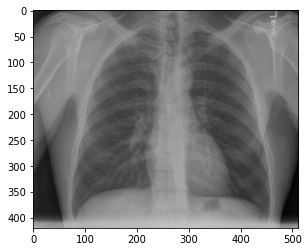

In [42]:
showSample(all_images,refs,cands)

In [43]:
pip install rouge_score

In [44]:
pip install nltk==3.6

     |████████████████████████████████| 1.5MB 9.4MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [45]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [46]:
# Metriklere göre doğruluk hesaplama sınıfı


import nltk 
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu

class Evaluation:
    def __init__(self,references,candidates):
        '''
        Args: References: gerçek değerler, 
              Candidates: bizim tahmin ettiklerimiz.
        '''
        self.references = references
        self.candidates = candidates

    def meteor_score_bul(self): 
        scores = list()
        gercek = ''
        tahmin = ''
        for index in range(len(self.references)):
            cumle_y = self.references[index][0]
            cumle_yhat = self.candidates[index]
            for word in cumle_y:
                gercek += ' ' + word
            for word in cumle_yhat:
                tahmin += ' ' + word
            score = meteor_score([gercek],tahmin)
            scores.append(score)
            #print(f"{index+1}.CALCULATION \nGERCEK:{gercek}\nTAHMIN:{tahmin}\n--> SCORE : {score}")
            gercek = ''
            tahmin = ''
        scores = np.array(scores)
        score_met = np.round(np.mean(scores),2)
        print("METEOR SCORE:",score_met)
        return scores,score_met

    def rouge_score_bul(self):
        print("ROUGE SCORE")
        scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'],use_stemmer=True)
        scores = list()
        gercek = ''
        tahmin = ''
        for index in range(len(self.references)):
            cumle_y = self.references[index][0]
            cumle_yhat = self.candidates[index]
            for word in cumle_y:
                gercek += ' ' + word
            for word in cumle_yhat:
                tahmin += ' ' + word
            score = scorer.score(gercek,tahmin)
            scores.append(score)
            #print(f"{index+1}.CALCULATION \nGERCEK:{gercek}\nTAHMIN:{tahmin}\n--> SCORE : {score}")
            gercek = ''
            tahmin = ''
        rouge_scores = scores
        precision_avg = np.round(np.array([rouge_scores[i]['rouge1'][0] for i in range(len(rouge_scores))]).mean(),2)
        recall_avg = np.round(np.array([rouge_scores[i]['rouge1'][1] for i in range(len(rouge_scores))]).mean(),2)
        f_measure_avg = np.round(np.array([rouge_scores[i]['rouge1'][2] for i in range(len(rouge_scores))]).mean(),2)
        print("\tROUGE-1 'e göre Skorlar:\n---------------------------------------")
        print(f"Precision:{precision_avg}\nRecall:{recall_avg}\nF_measure:{f_measure_avg}")
        precision_avg = np.round(np.array([rouge_scores[i]['rougeL'][0] for i in range(len(rouge_scores))]).mean(),2)
        recall_avg = np.round(np.array([rouge_scores[i]['rougeL'][1] for i in range(len(rouge_scores))]).mean(),2)
        f_measure_avg = np.round(np.array([rouge_scores[i]['rougeL'][2] for i in range(len(rouge_scores))]).mean(),2)
        print("\n---------------------------------------\n\tROUGE-L 'e göre Skorlar:\n---------------------------------------")
        print(f"Precision:{precision_avg}\nRecall:{recall_avg}\nF_measure:{f_measure_avg}")
        return rouge_scores

    def bleu_score_bul(self):
        bleus = []
        b1 = np.round(corpus_bleu(self.references, self.candidates, weights=(1.0, 0, 0, 0)),2)
        b2 = np.round(corpus_bleu(self.references, self.candidates, weights=(0.5, 0.5, 0, 0)),2)
        b3 = np.round(corpus_bleu(self.references, self.candidates, weights=(0.3, 0.3, 0.3, 0)),2)
        b4 = np.round(corpus_bleu(self.references, self.candidates, weights=(0.25, 0.25, 0.25, 0.25)),2)
        print('BLEU-1:',b1)
        print('BLEU-2:',b2)
        print('BLEU-3:',b3)
        print('BLEU-4:',b4)
        bleus.append(b1)
        bleus.append(b2)
        bleus.append(b3)
        bleus.append(b4)
        return bleus

    def evaluateModelAsMetrics(self):
        bleus = self.bleu_score_bul()
        met_scores,met_score = self.meteor_score_bul()
        rouge_scores = self.rouge_score_bul()
        return bleus,met_scores,rouge_scores


In [47]:
evalMetrics = Evaluation(refs,cands)
scores = evalMetrics.evaluateModelAsMetrics()

BLEU-1: 0.31
BLEU-2: 0.19
BLEU-3: 0.16
BLEU-4: 0.09
METEOR SCORE: 0.31
ROUGE SCORE
	ROUGE-1 'e göre Skorlar:
---------------------------------------
Precision:0.38
Recall:0.38
F_measure:0.36

---------------------------------------
	ROUGE-L 'e göre Skorlar:
---------------------------------------
Precision:0.3
Recall:0.29
F_measure:0.28


In [48]:
model_dosya_ismi = os.path.join(kayit_yeri,'modeller','mybasetransformer_model19haziran_weights')
prediction_model.save_weights(model_dosya_ismi,save_format='tf')

In [50]:
tknzrmap_dosyayolu = os.path.join(kayit_yeri,'modeller','mytknzr.pkl')
tknzrmap = {'tknzr':tokenizer,'seq_len':SEQ_LENGTH}
helper.saveToFile(tknzrmap,tknzrmap_dosyayolu)

/content/drive/MyDrive/bm496_7haziran/modeller/mytknzr.pkl dosya kaydedildi


In [51]:
transformer_prediction = Transformer(NUM_LAYER,EMBED_DIM,NHEADS,FFN_DIM,ROW_SIZE,COL_SIZE,VOCABSIZE,rate=DROPOUT_RATE)
transformer_prediction.load_weights(model_dosya_ismi)

In [64]:
def generateOneCaption(image,extraction_model,prediction_model,tokenizer,SEQ_LENGTH):
   temp_input = tf.expand_dims(goruntuYukle(image)[0], 0)
   img_tensor_val = extraction_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]

   output = tf.expand_dims(decoder_input, 0) #tokens
   predicted_words = [] #word list
   #print("Inıtial: Outpu:",output,"\nDeocder_inp:",decoder_input,"\nstart_token:",start_token)
   for i in range(SEQ_LENGTH):
      dec_mask = create_masks_decoder(output)
      predictions,_ = prediction_model(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         predicted_caption = [' '.join(pred_word for pred_word in predicted_words)]
         return predicted_caption[0] # tek elemanlı liste 
      predicted_words.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)
      #print("output:",output,"\noutput.shape:",output.shape)
      #print("predicted_id:",predicted_id)
   predicted_caption = [' '.join(pred_word for pred_word in result)]
   return predicted_caption[0] # tek elemanlı liste 

In [63]:
pred = generateOneCaption(img_fullpaths_test[33],extraction_model,transformer_prediction,tokenizer,SEQ_LENGTH)
print("pred:",pred)

pred: right picc tip overlying right atrium no pneumothorax large pleural effusion cardiac silhouette mediastinal contours within normal limits


In [69]:
pred = generateOneCaption(img_fullpaths_test[18],extraction_model,transformer_prediction,tokenizer,SEQ_LENGTH)
print("pred:",pred)

pred: heart size mediastinal contours within normal limits pulmonary vasculature unremarkable no focal consolidation no visible pleural effusion pneumothorax no acute bony abnormality
